# 数据导入

In [ ]:
import os

data_dir = 'F:/pyproject/REcurrent/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')    # header of data for each column, shape(1,15) 
lines = lines[1:]    # pure data, shape(420451,1)

print(header)
print(len(lines))
print(len(header))

## 解析数据

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))    # zero array in (420451, 14)
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]    # without first column
    float_data[i, :] = values
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

## 绘制温度时间序列

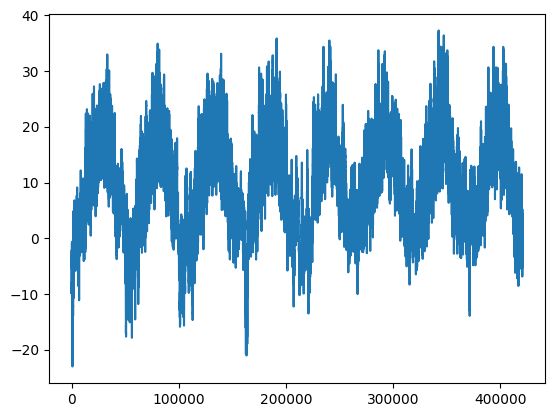

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

## 绘制前10天温度时间序列

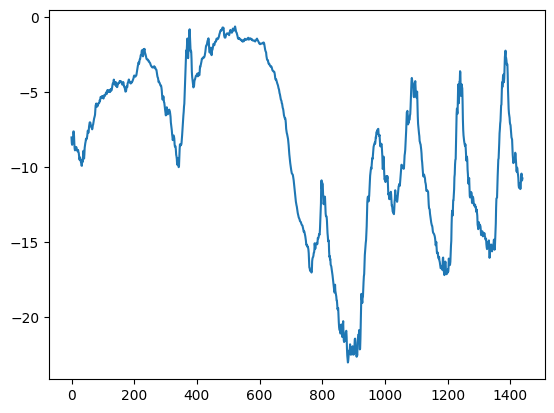

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

# 准备数据
问题描述：一个时间步是10分钟，每steps个时间步采样一次数据，给定过去lookback个时间步之内的数据，能否预测delay个时间步之后的温度？将使用以下参数。
lookback = 720，给定过去5天的数据。
steps = 6，观测数据的采样频率是每小时一个数据点。
delay = 144，目标是未来24小时之后的数据。

## 数据预处理
我们不能将整数序列直接输入ANN，要把整数序列（变量类型一般为列表）转化为张量。需要将数据变成神经网络可以处理的格式，转换方法有两种：1填充列表，使其具有相同的长度，再将列表转化成形状是（samples，word_indices）的整数张量，然后网络第一层使用能够处理这种整数张量的层--Embedding层。2对列表进行one-hot编码，将其转化为0和1组成的向量。数据已经是数值型的，不用再向量化，只需要对每个时间序列分别进行标准化，让他们在相似范围内取较小值。预处理方法是：将每个时间序列减去其平均值，然后除以其标准差。我们使用前200,000个时间步作为训练数据，所以只对这部分数据计算平均值和标准差。

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## 编写Python生成器
以当前的浮点数数组为输入，并从最近的数据生成数据批量，同时生成未来的目标温度。因为数据集中的样本高度冗余（对于第N个样本和第N+1个样本，大部分时间步都是相同的），所以显式保存每个样本过于浪费，我们将使用原始数据即时生成样本。

### 生成时间序列样本及其目标的生成器
生成结果为一个元组（samples，targets），其中samples是输入数据的一个批量，targets是对应的目标温度数组，参数介绍——
data：浮点数数据组成的原始数组，在上一步中被标准化
lookback：输入数据应该包括过去多少个时间步
delay：目标应该在未来多少个时间步之后
min_index和max_index：data数组中的索引，用于界定需要抽取哪些时间步，有助于保存一部分数据用于验证，一部分用于测试
shuffle：是打乱样本，还是按顺序抽取样本
batch_size：每个批量的样本数
step：数据采样的周期（单位：时间步），这里设置为6，为的是每小时抽取一个数据点。

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:    # 仅对测试生成器用
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:  # dead cycle
        if shuffle:    # randomly pick up each datapoint
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)    # 重复赋值，该值被r11覆盖
        else:  # pick up in order
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arrange(i, min(i + batch_size, max_index))    # 产生一个数列，等差为1，从i开始，到i + batch_size与max_index中比较小的那个
            i += len(rows)
            
        samples = np.zeros((len(rows),lookback // step, data.shape[-1]))    # shape[-1]返回该数组最后一维的长度
        targets = np.zeros((len(rows),))
        for j, row in  enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### 准备训练、验证和测试生成器
generator函数实例化三个生成器：一个用于训练，一个用于验证，一个用于测试。每个生成部分分别读取原始数据的不同时间段：训练器读前200，000个时间步，验证器读取随后的100,000步，测试其读取剩下的时间步。

In [5]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,     # test_gen was not used
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_steps = (300000 - 200001 -lookback) // batch_size

test_steps = (len(float_data) - 300001 -lookback) // batch_size

## 建立最低标准
在进行机器学习预测温度之前，我们最好有一个最低的标准，可评估预测结果是否可靠，一种基于常识的方法就是始终预测24小时后的温度等于现在的温度，我们使用平均绝对误差（MAE）指标来评估这种方法。

In [6]:
def evaluate_native_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_native_method()

0.29055739289900284


## 将MAE转化成摄氏温度误差 

In [7]:
celsius_mae = 0.29 * std[1]
print(celsius_mae)

2.5672247338393395


# 构建模型并训练 

## 训练并评估一个密集连接模型 
尝试机器学习方法之前，建立一个基于常识的基准方法是很有用的，同样，在开始研究复杂且计算代价很高的模型（如RNN）之前尝试使用简单且计算代价低的机器学习模型也是很有用的，比如小型密集网络。下面给出一个密集连接模型，首先将数据展平，然后通过两个Dense层并运行，最后一个Dense层没有使用激活函数，这对于回归问题是很常见的。我们使用MAE作为损失，评估数据和评估指标都与常识方法完全相同，所以可以直接比较两种方法的结果。

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8792\3204401368.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/20
500/500 [==============================] - 15s 25ms/step - loss: 1.5757 - val_loss: 0.8434
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.4977 - val_loss: 0.3486
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2996 - val_loss: 0.3031
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2698 - val_loss: 0.3146
Epoch 5/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2566 - val_loss: 0.3019
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2471 - val_loss: 0.3143
Epoch 7/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2390 - val_loss: 0.3586
Epoch 8/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2324 - val_loss: 0.3527
Epoch 9/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2265 - val_loss: 0.3806
Epoch 10/20
500/500 [==============================] - 12s 25ms/step - loss: 0.221

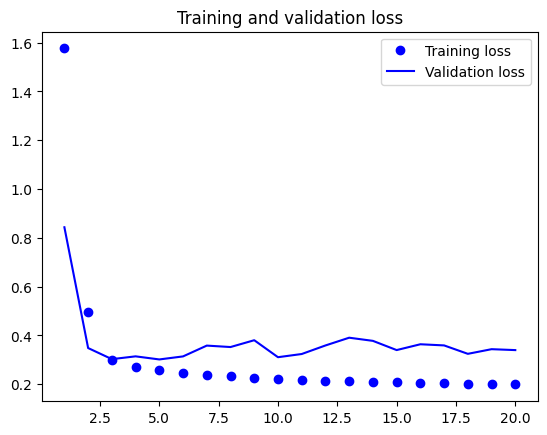

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 测试与预测结果

In [16]:
loss = model.evaluate(test_gen, batch_size=32, steps=test_steps)
print('\ntest loss:', loss)

929/929 [==============================] - 9s 10ms/step - loss: 0.3423

test loss: 0.34226787090301514


929/929 [==============================] - 9s 10ms/step


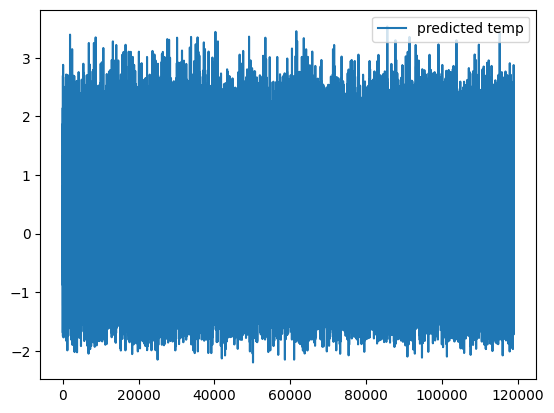

In [19]:
predictions = model.predict(test_gen, steps=test_steps)
steps = range(1, len(predictions) + 1)
plt.plot(steps, predictions, label='predicted temp')
plt.legend()
plt.show()

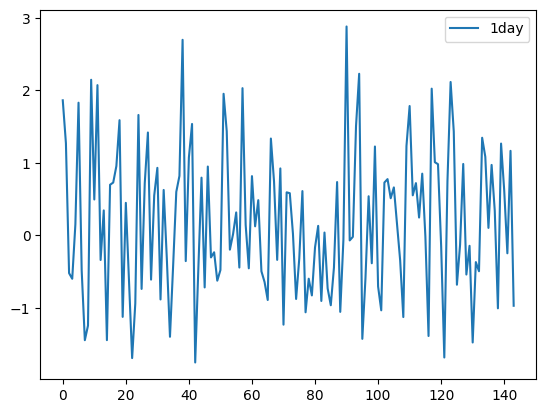

In [21]:
plt.plot(range(144), predictions[:144], label='1day')
plt.legend()
plt.show()

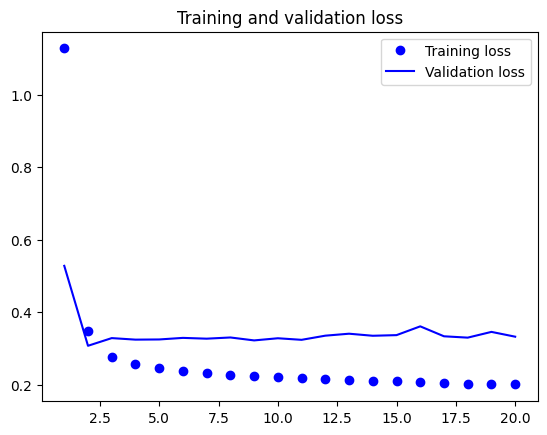

In [12]:
# 最符合书上的某次训练结果
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

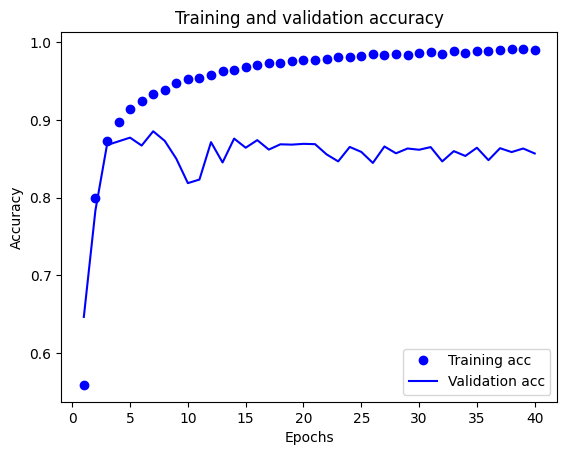

In [27]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 第一个循环网络基准
第一个全连接方法效果并不好，因其首先将时间序列展平（Flatten），这从输入数据中删除了时间的概念，这个数据本是一个序列，其中因果关系和顺序都很重要。接下来尝试一种循环序列处理模型，它将利用数据点的时间顺序：GRU层（由Chung等人在2014年开发），门控循环单元（GRU，Gated recurrent unit）层的工作原理和LSTM相同，但运行的计算代价更低。

In [14]:
from keras.models import Sequential
from keras  import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5196\360912738.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 57s 100ms/step - loss: 0.3100 - val_loss: 0.2745
Epoch 2/20
500/500 [==============================] - 50s 99ms/step - loss: 0.2864 - val_loss: 0.2722
Epoch 3/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2806 - val_loss: 0.2660
Epoch 4/20
500/500 [==============================] - 52s 105ms/step - loss: 0.2765 - val_loss: 0.2675
Epoch 5/20
500/500 [==============================] - 53s 107ms/step - loss: 0.2724 - val_loss: 0.2643
Epoch 6/20
500/500 [==============================] - 55s 110ms/step - loss: 0.2680 - val_loss: 0.2594
Epoch 7/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2654 - val_loss: 0.2600
Epoch 8/20
500/500 [==============================] - 51s 102ms/step - loss: 0.2589 - val_loss: 0.2629
Epoch 9/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2557 - val_loss: 0.2684
Epoch 10/20
500/500 [==============================] - 51s 101ms/step - loss: 0.2517 

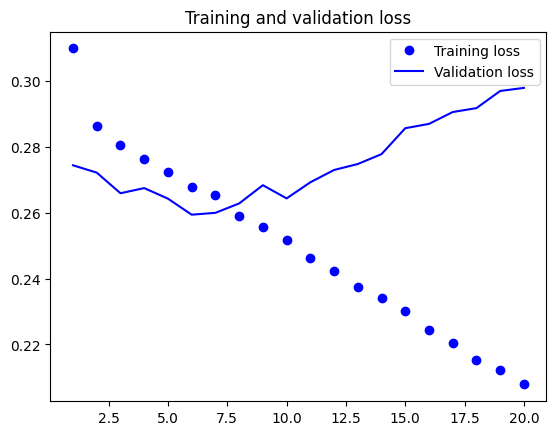

In [15]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

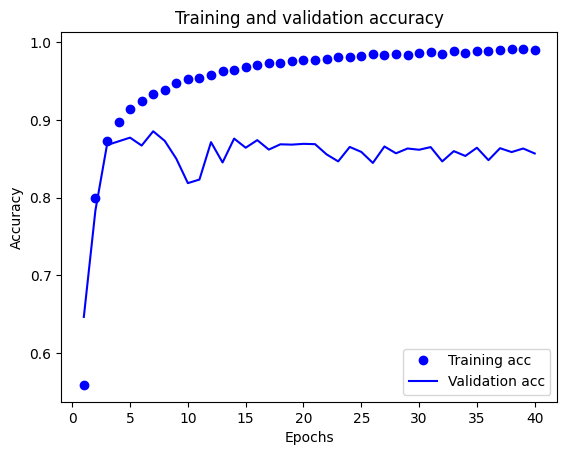

In [28]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

新的验证MAE约为0.265（在开始显著过拟合之前），反标准化转化成温度的平均绝对误差为2.35℃。与最初的误差2.57℃相比，结果有提高。

## 使用循环dropout降低过拟合
上个模型中，几轮过后。训练损失和验证损失开始显著偏离。利用dropout：将某一层的输入单元随机设为0，可用于打破该层训练数据中偶然相关性。

### dropout正则化的GRU模型
对每个时间步应该使用相同的dropout掩码（dropout mask，相同模式的舍弃单元），而不是让dropout掩码随着时间步的增加而随机变化，为了对GRU、LSTM等循环层得到的表示做正则化，应该将不随时间变化的dropout掩码应用于层的内部循环激活（循环dropout掩码）。这种机制内置于keras中，每个keras循环层都有两个与dropout相关的参数：一个是dropout，一个浮点数，指定该层输入单元的dropout比率，另一个是recurrent_dropout，指定循环单元的dropout比率。

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2, 
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5196\2680843840.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 84s 162ms/step - loss: 0.3266 - val_loss: 0.2798
Epoch 2/40
500/500 [==============================] - 82s 163ms/step - loss: 0.3067 - val_loss: 0.2737
Epoch 3/40
500/500 [==============================] - 81s 162ms/step - loss: 0.3003 - val_loss: 0.2723
Epoch 4/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2967 - val_loss: 0.2685
Epoch 5/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2929 - val_loss: 0.2723
Epoch 6/40
500/500 [==============================] - 80s 161ms/step - loss: 0.2878 - val_loss: 0.2734
Epoch 7/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2858 - val_loss: 0.2737
Epoch 8/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2828 - val_loss: 0.2745
Epoch 9/40
500/500 [==============================] - 80s 161ms/step - loss: 0.2789 - val_loss: 0.2723
Epoch 10/40
500/500 [==============================] - 81s 161ms/step - loss: 0.2751

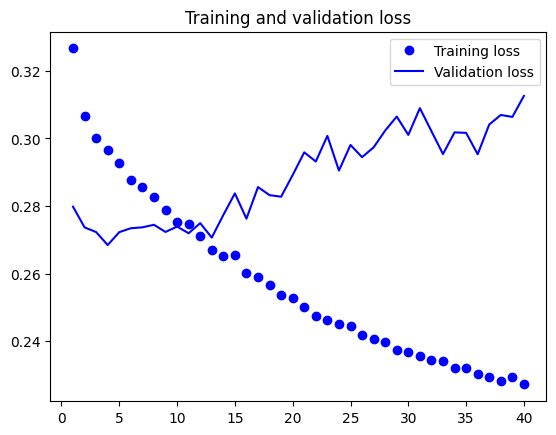

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

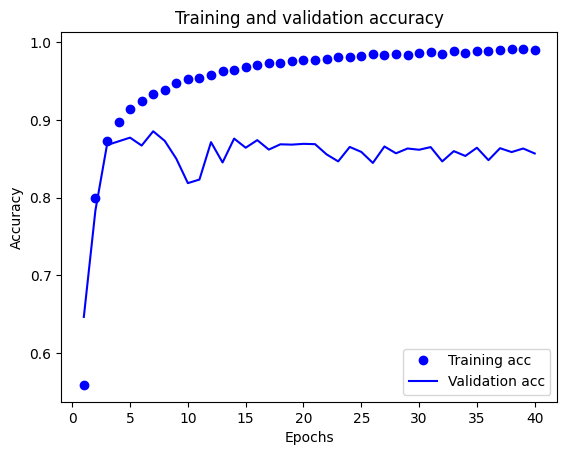

In [29]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 循环层堆叠
增加网络容量，只要过拟合不是太严重，那么很可能是容量不足的问题。通常增加容量的做法是：增加每层单元数或增加层数。循环层堆叠（recurrent layer stacking）是构件更强大的循环网络的方法（谷歌翻译算法就是7个大型LSTM层堆叠）。在keras中逐个堆叠循环层，所有中间层都应该范围完整的输出序列，可以通过指定return_sequences=True来实现。

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5196\3162716598.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/40
500/500 [==============================] - 261s 510ms/step - loss: 0.3189 - val_loss: 0.2824
Epoch 2/40
500/500 [==============================] - 247s 495ms/step - loss: 0.3031 - val_loss: 0.2805
Epoch 3/40
500/500 [==============================] - 253s 506ms/step - loss: 0.2960 - val_loss: 0.2734
Epoch 4/40
500/500 [==============================] - 256s 512ms/step - loss: 0.2881 - val_loss: 0.2689
Epoch 5/40
500/500 [==============================] - 249s 499ms/step - loss: 0.2811 - val_loss: 0.2742
Epoch 6/40
500/500 [==============================] - 251s 502ms/step - loss: 0.2748 - val_loss: 0.2694
Epoch 7/40
500/500 [==============================] - 264s 528ms/step - loss: 0.2697 - val_loss: 0.2717
Epoch 8/40
500/500 [==============================] - 267s 534ms/step - loss: 0.2651 - val_loss: 0.2763
Epoch 9/40
500/500 [==============================] - 261s 522ms/step - loss: 0.2621 - val_loss: 0.2776
Epoch 10/40
500/500 [==============================] - 259s 517m

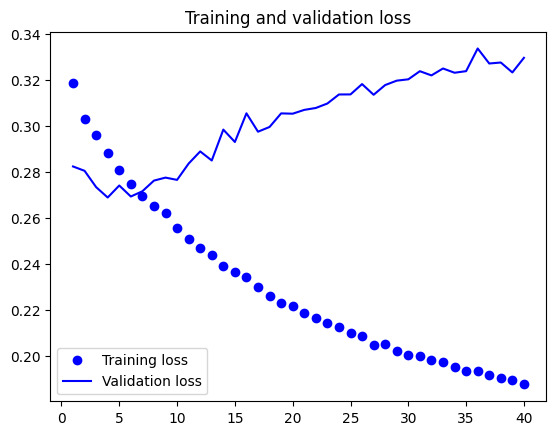

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

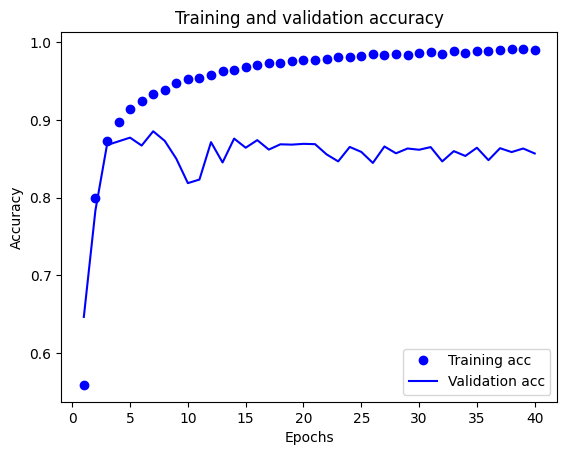

In [30]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 训练一个双向GRU

In [20]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32),input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_5196\656305458.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


Epoch 1/40
500/500 [==============================] - 118s 169ms/step - loss: 0.2957 - val_loss: 0.2798
Epoch 2/40
500/500 [==============================] - 79s 159ms/step - loss: 0.2767 - val_loss: 0.2721
Epoch 3/40
500/500 [==============================] - 80s 159ms/step - loss: 0.2681 - val_loss: 0.2759
Epoch 4/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2624 - val_loss: 0.2629
Epoch 5/40
500/500 [==============================] - 80s 159ms/step - loss: 0.2544 - val_loss: 0.2633
Epoch 6/40
500/500 [==============================] - 79s 159ms/step - loss: 0.2496 - val_loss: 0.2733
Epoch 7/40
500/500 [==============================] - 80s 159ms/step - loss: 0.2416 - val_loss: 0.2742
Epoch 8/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2347 - val_loss: 0.2911
Epoch 9/40
500/500 [==============================] - 81s 162ms/step - loss: 0.2270 - val_loss: 0.2799
Epoch 10/40
500/500 [==============================] - 81s 162ms/step - 

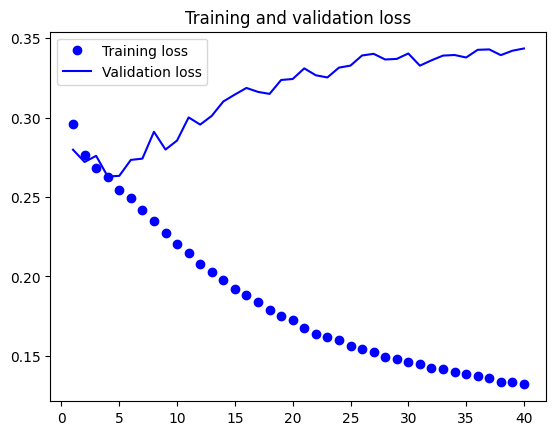

In [21]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

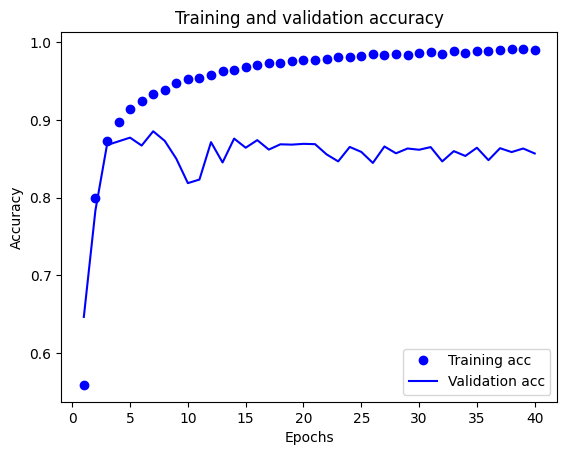

In [31]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 以下是文本识别与房价预测

## 使用逆序序列训练并评估一个LSTM
一个单词对理解句子的重要性通常不取决于它在句子中的位置。

In [22]:
from keras.datasets import imdb
from keras.utils import pad_sequences
from keras import layers
from keras.models import Sequential

max_features = 10000    # 作为特征的单词个数
maxlen = 500    # 在这么多单词之后截断文本

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)    # 加载数据

x_train = [x[::-1] for x in x_train] 
x_test = [x[::-1] for x in x_test]   # 将序列反转

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)    # 填充序列

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,y_train,
                    epochs=40,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,300,641
Trainable params: 1,300,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
157/157 [==============================] - 60s 361ms/step - loss: 0.5952 - acc: 0.6718 - val_loss: 0.4117 - val_acc: 0.8340
Epoch 2/40
157/157 [==============================] - 57s 363ms/step - loss: 0.3943 - acc: 0.8403 - val_loss: 0.3588 - val_acc: 0.8560
Epoch 3/40
157/157 [==================

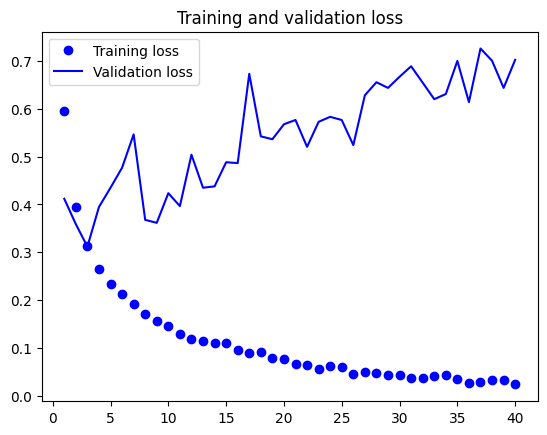

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
from keras import layers
from keras.models import Sequential

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/40
157/157 [==============================] - 86s 422ms/step - loss: 0.6771 - acc: 0.5586 - val_loss: 0.6126 - val_acc: 0.6462
Epoch 2/40
157/157 [==============================] - 66s 422ms/step - loss: 0.4642 - acc: 0.7997 - val_loss: 0.5980 - val_acc: 0.7832
Epoch 3/40
157/157 [==============================] - 68s 432ms/step - loss: 0.3325 - acc: 0.8727 - val_loss: 0.3348 - val_acc: 0.8676
Epoch 4/40
157/157 [==============================] - 66s 418ms/step - loss: 0.2789 - acc: 0.8979 - val_loss: 0.3179 - val_acc: 0.8724
Epoch 5/40
157/157 [==============================] - 66s 419ms/step - loss: 0.2412 - acc: 0.9137 - val_loss: 0.3216 - val_acc: 0.8772
Epoch 6/40
157/157 [==============================] - 66s 418ms/step - loss: 0.2141 - acc: 0.9241 - val_loss: 0.3354 - val_acc: 0.8670
Epoch 7/40
157/157 [==============================] - 66s 419ms/step - loss: 0.1887 - acc: 0.9341 - val_loss: 0.3296 - val_acc: 0.8854
Epoch 8/40
157/157 [==============================] - 6

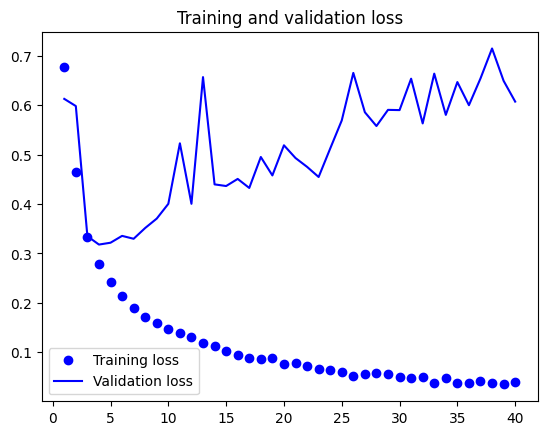

In [25]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

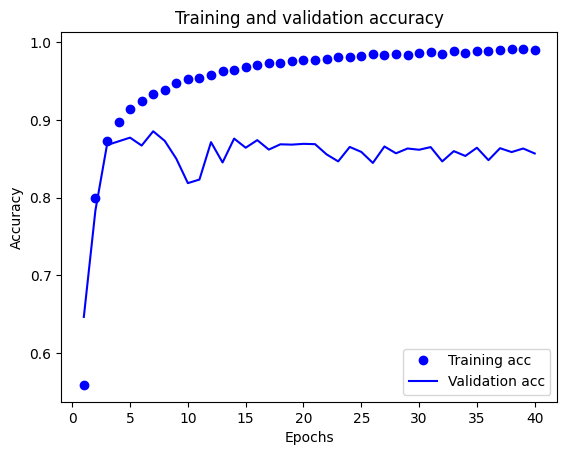

In [32]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 波士顿房价问题 

### 数据导入 
可以看到我们有404个训练样本(test_data)和102个测试样本(train_data)，每个样本有13个特征，如人均犯罪率、每个住宅的平均房间数、高速公路可达性等.房价(train_target)在10k~50k美元之间

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
train_data.shape


(404, 13)

In [19]:
test_data.shape

(102, 13)

In [3]:
train_targets.shape

(404,)

### 标准化

In [21]:
# 对数据进行标准化，减去特征平均值，再除以标准差
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### 模型定义 

In [22]:
# 模型定义
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64,activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

### K折验证
将数据集划分为训练集和验证集。数据少时验证集小，验证分数可能会有很大的波动，数值上表现为验证分数方差很大，这时采用K折交叉验证把数据划分为K个分区，实例化K-1个相同模型，将每个模型在K-1个分区上训练，并在剩下一个分区上评估。最终的模型验证分数取K个验证分数的平均值。

In [23]:
# K折验证
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, 
              epochs=num_epochs,batch_size=1,verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [24]:
all_scores

[1.9975799322128296,
 2.5688207149505615,
 2.7654545307159424,
 2.5149002075195312]

In [25]:
np.mean(all_scores)

2.461688846349716

### 保存每折的验证结果

In [26]:
from keras import models
from keras import layers
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
        
    model = build_model()
    history = model.fit(partial_train_data,partial_train_targets,
                        validation_data=(val_data,val_targets),
                        epochs=num_epochs,batch_size=1,verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [27]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 绘制验证分数

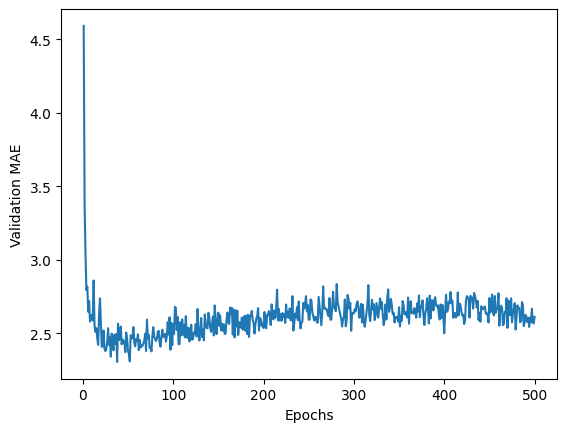

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 重绘验证分数
①删除前10个数据点，因为这些点取值与其他点不同
②将每个数据点替换为前面数据点的指数移动平均值。
可以观察到MAE在80轮以后就不再降低，之后开始过拟合

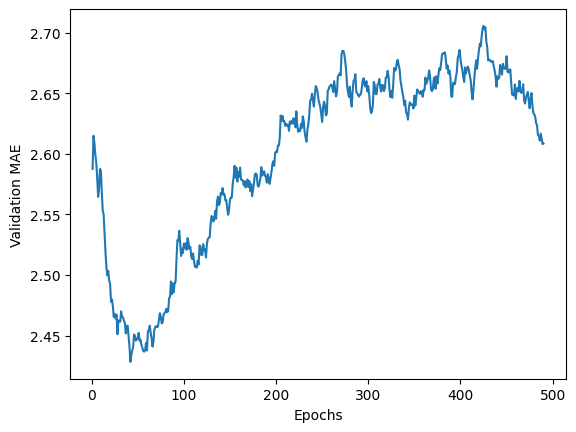

In [29]:
  def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history  = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 训练最终模型

In [30]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16,verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 0s/step - loss: 17.2339 - mae: 2.6359


In [31]:
# 最终结果如下
test_mae_score

2.6358749866485596

## 以下是股票预测

In [28]:
import numpy as np

filename = 'G:/EdgeDownload/sinewave.csv'
with open(filename, 'rt') as raw_data:
    iris=np.loadtxt(raw_data,delimiter=',')
    print(iris)
    print(iris.shape)



[0.84147098 0.8737364  0.90255357 ... 0.7671179  0.80588467 0.84147098]
(5001,)


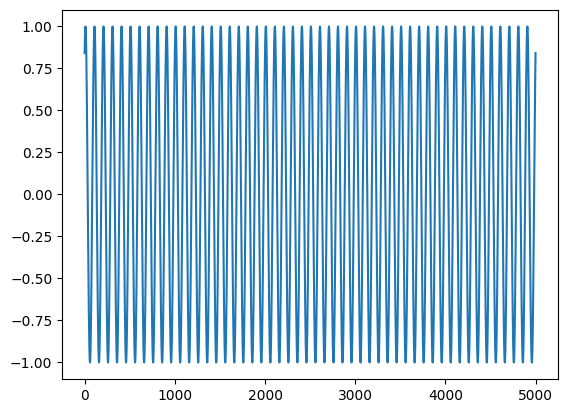

In [29]:
import matplotlib.pyplot as plt

temp1 = iris[:]
plt.plot(range(len(temp1)), temp1)
plt.show()

In [30]:
import pandas as pd
class DataLoader():
    # 用于为LSTM模型加载和转换数据的类
    def __init__(self, filename, split, cols):    # 初始化
        dataframe = pd.read_csv(filename)    # 数据读取
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]     # 训练集
        self.data_test = dataframe.get(cols).values[i_split:]    # 测试集
        self.len_train = len(self.data_train)
        self.len_test = len(self.data_test)
        self.len_train_windows = None

In [9]:
class Model():
    # 一个用于构建和推断LSTM模型的类
    def __init__(self):
        self.model = Sequential()
    def load_model(self, filepath):    # 加载模型
        print('[model] Loading model from file % s' % filepath)
        self.model = load_model(filepath)
    def build_model(self, configs):    # 构建模型
        timer = Timer()
        timer.start()
        for layer in configs['model']['layers']:    # 参数定义
            neurons = layer['neurons'] if 'neurons' in layer else None
            dropout_rate = layer['rate'] if 'rate' in layer else None
            activation = layer['activation'] if 'activation' in layer else None
            return_seq = layer['return_seq'] if 'return_seq' in layer else None
            input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
            if layer['type'] == 'dense':     # 类型为dense
                self.model.add(Dense(neurons, activation=activation))
            if layer['type'] == 'lstm':    # 类型为LSTM
                self.model.add(LSTM(neurons,input_shape=(input_timesteps,input_dim),return_sequences=return_seq))
            if layer['type'] == 'dropout':    # 丢弃率
                self.model.add(Dropout(dropout_rate))
         # 定义损失函数和优化器
    self.model.compile(loss=configs['model']['loss'],optimizer=configs['model']['optimizer'])# 在config.json文件中看到对损失函数和优化模型的配置

## 损失函数和优化器
确定模型架构后进行编译，使用Keras官网定义的MSE均方误差作为损失函数，Adam作为梯度下降方法来优化模型参数。

In [32]:
         # 定义损失函数和优化器
    self.model.compile(loss=configs['model']['loss'],optimizer=configs['model']['optimizer'])# 在config.json文件中看到对损失函数和优化模型的配置
    "model":{
        "loss": "mse",
        "optimizer": "adam",
        "save_dir": "save_models",
        "layers":[
            {
                "type": "lstm",
                "neurons": 100,
                "input_timesteps": 49,
                "input_dim": 2,
                "return_seq": true
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type" : "lstm",
                "neurons": 100,
                "return_seq": true
            },
            {
                "type": "lstm",
                "neurons": 100,
                "return_seq": false
            },
            {
                "type": "dropout",
                "rate": 0.2
            },
            {
                "type": "dense",
                "rate": 1,
                "activation": "linear"
            }
        ]
    } 

IndentationError: unexpected indent (3463826414.py, line 2)

## 模型保存及输出预测
在定义模型架构和编译以后，使用训练集训练模型，使模型预测曲线走向。这里将使用训练集和测试集拟合并保存模型。加载数据并构建模型后，继续使用训练数据对模型进行训练。为此，创建单独的运行模块，该模块利用Model和DataLoader将它们组合起来进行训练、输出和可视化。

In [1]:
    # 创建model类中的训练模型
    import os
    class Model():
        def train(self, x, y, epochs, batch_size, save_dir):    # 定义训练参数
            timer = Timer()
            timer.start()
            print('[Model] Training Started')
            print('[Model] % s epochs, % s batch_size' % (epochs, batch_size))
            save_fname = os.path.join(save_dir, '% s - e % s.h5' % (dt.datetime.now().strftime('% d % m % Y - % H % M % S'), str(epochs)))    # 保存文件
            callbacks = [ # 回调函数
                EarlyStopping(monitor='val_loss',patience=2),
                ModelCheckpoint(filepath=save_fname,monitor='val_loss',save_best_only=true)
            ]
    # 使用model.fit()方法
            self.model.fit(
                x,
                y,
                epochs = epochs,
                batch_size = batch_size,
                callbacks = callbacks
            )
            self.model.save(save_fname)    # 保存模型
        print('[model] Training Completed. Model saved as % s save_fname')
            timer.stop()
            
    # 模块实例化
    configs = json.load(open('config.json', 'r'))
    data = DataLoader( # 加载数据 
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )
    model = Model()
    # 创建模型，传入参数
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len = configs['data']['sequence_length'],
        normalise = configs['data']['normalise']
    )
    x_test, y_test = data.get_test_data( # 获取测试数据 
        seq_len = configs['data']['sequence_length'],
        normalise = configs['data']['normalise']
    )
 # 使用model.save()方法将模块保存在指定路径中，方便其他程序调用。  
        

IndentationError: unexpected indent (3060852041.py, line 24)

In [14]:
import pandas as pd
import numpy as np
# pd.DataFrame([data, index, columns, dtype, copyright])
data = pd.DataFrame(np.arange(10,26).reshape((4, 4)),
                index=['Ohio', 'Colorado', 'Utah', 'New York'],
                columns=['one', 'two', 'three', 'four'])
data

,one,two,three,four
Ohio,10,11,12,13
Colorado,14,15,16,17
Utah,18,19,20,21
New York,22,23,24,25


In [17]:
import numpy as np
import pandas as pd
data = {'state': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
       'year': [2000, 2001, 2002, 2001, np.nan],
       'pop': [1.5, 1.7, 3.6, 2.4, 2.9]}
pd.DataFrame(data,)

,state,year,pop
0,Ohio,2000.0,1.5
1,Ohio,2001.0,1.7
2,Ohio,2002.0,3.6
3,Nevada,2001.0,2.4
4,Nevada,NaN,2.9


In [23]:
import numpy as np
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[11, 21,31], [7, 8, 9]])
c = np.concatenate((a, b),axis=0)
d = np.concatenate((a, b),axis=1)
print(a)
print(b)
print(c)
print(d)

[[1 2 3]
 [4 5 6]]
[[11 21 31]
 [ 7  8  9]]
[[ 1  2  3]
 [ 4  5  6]
 [11 21 31]
 [ 7  8  9]]
[[ 1  2  3 11 21 31]
 [ 4  5  6  7  8  9]]


In [30]:
    from time import perf_counter as now
    a=np.arange(9999)
    b=np.arange(9999)
    time1=now()
    c=np.append(a,b)
    time2=now()
    print("time consuming by append:",time2-time1)
    a=np.arange(9999)
    b=np.arange(9999)
    time1=now()
    c=np.concatenate((a,b),axis=0)
    time2=now()
    print("time consuming by concatenate:",time2-time1)

time consuming by append: 0.0002591579977888614
time consuming by concatenate: 0.00011482498666737229


In [8]:
    import pandas as pd
    data = pd.DataFrame()
    a = [1, 2, 3]
    data = data.append(data.append(a))
    print(data)

   0
0  1
1  2
2  3


In [9]:
    import pandas as pd
    data = pd.DataFrame()
    a = [[1, 2, 3]]
    data = data.append(data.append(a))
    print(data)

   0  1  2
0  1  2  3


In [10]:
    import pandas as pd
    data = pd.DataFrame()
    a = [[[1, 2, 3]]]
    data = data.append(data.append(a))
    print(data)

           0
0  [1, 2, 3]
